In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ip02-dataset/val.txt
/kaggle/input/ip02-dataset/test.txt
/kaggle/input/ip02-dataset/train.txt
/kaggle/input/ip02-dataset/classes.txt
/kaggle/input/ip02-dataset/classification/val/7/04772.jpg
/kaggle/input/ip02-dataset/classification/val/7/04586.jpg
/kaggle/input/ip02-dataset/classification/val/7/04688.jpg
/kaggle/input/ip02-dataset/classification/val/7/05038.jpg
/kaggle/input/ip02-dataset/classification/val/7/04298.jpg
/kaggle/input/ip02-dataset/classification/val/7/04838.jpg
/kaggle/input/ip02-dataset/classification/val/7/04709.jpg
/kaggle/input/ip02-dataset/classification/val/7/04430.jpg
/kaggle/input/ip02-dataset/classification/val/7/04600.jpg
/kaggle/input/ip02-dataset/classification/val/7/04394.jpg
/kaggle/input/ip02-dataset/classification/val/7/04927.jpg
/kaggle/input/ip02-dataset/classification/val/7/04751.jpg
/kaggle/input/ip02-dataset/classification/val/7/04339.jpg
/kaggle/input/ip02-dataset/classification/val/7/05072.jpg
/kaggle/input/ip02-dataset/classification

In [2]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import seaborn as sns

2025-05-23 05:50:29.298363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 05:50:29.298482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 05:50:29.423190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load class labels
f = open('/kaggle/input/ip02-dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label', 'name']

In [4]:
# Load train, validation, and test data
train_df = pd.read_csv('/kaggle/input/ip02-dataset/train.txt', sep=' ', header=None, engine='python')
train_df.columns = ['image_path', 'label']

test_df = pd.read_csv('../input/ip02-dataset/test.txt', sep=' ', header=None, engine='python')
test_df.columns = ['image_path', 'label']

val_df = pd.read_csv('../input/ip02-dataset/val.txt', sep=' ', header=None, engine='python')
val_df.columns = ['image_path', 'label']

In [5]:
# Filter specific classes
choose_label_index = (15, 22, 24, 39, 50, 51, 58, 67, 70, 101)
class_filter = classes.loc[classes['label'].isin(choose_label_index)]

train_df_img = train_df[train_df['label'].isin(choose_label_index)].copy().reset_index(drop=True)
val_df_img = val_df[val_df['label'].isin(choose_label_index)].copy().reset_index(drop=True)
test_df_img = test_df[test_df['label'].isin(choose_label_index)].copy().reset_index(drop=True)

TRAIN_DIR = '../input/ip02-dataset/classification/train'
TEST_DIR = '../input/ip02-dataset/classification/test'
VAL_DIR = '../input/ip02-dataset/classification/val'
#EPOCH = 10


train_df_img['image_fullpath'] = TRAIN_DIR + "/" + train_df_img['label'].astype(str) + "/" + train_df_img['image_path']
val_df_img['image_fullpath'] = VAL_DIR + "/" + val_df_img['label'].astype(str) + "/" + val_df_img['image_path']
test_df_img['image_fullpath'] = TEST_DIR + "/" + test_df_img['label'].astype(str) + "/" + test_df_img['image_path']

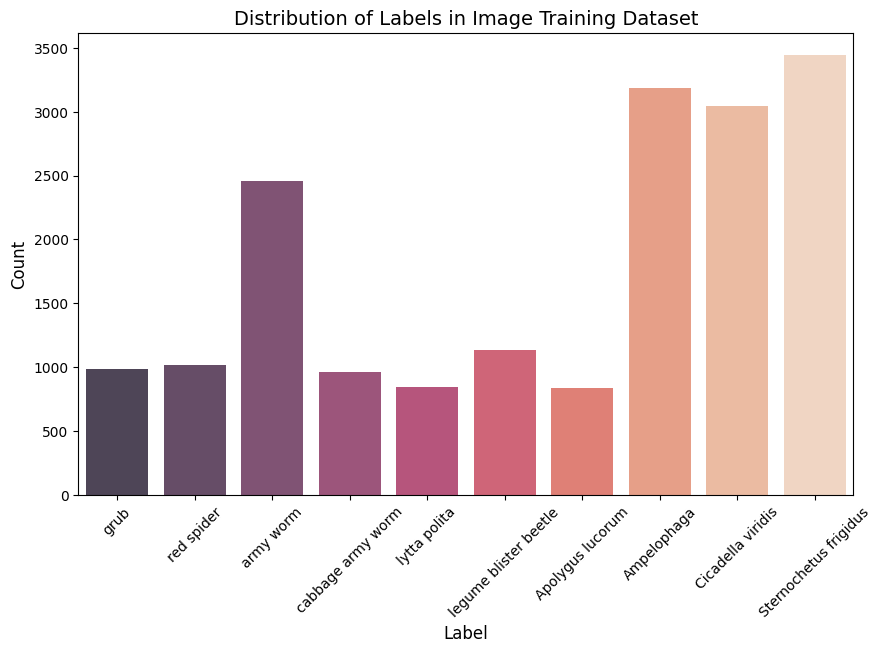

In [6]:
# Display label distribution
label_counts = train_df_img['label'].value_counts()
merged_df = pd.merge(label_counts, class_filter, on='label', how='outer')

plt.figure(figsize=(10, 6))
sns.barplot(x="name", y="count", data=merged_df, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Training Dataset', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [7]:
def get_lable(num):
    return class_filter.loc[class_filter["label"] ==num,"name"].values[0]

get_lable(15)

'grub'

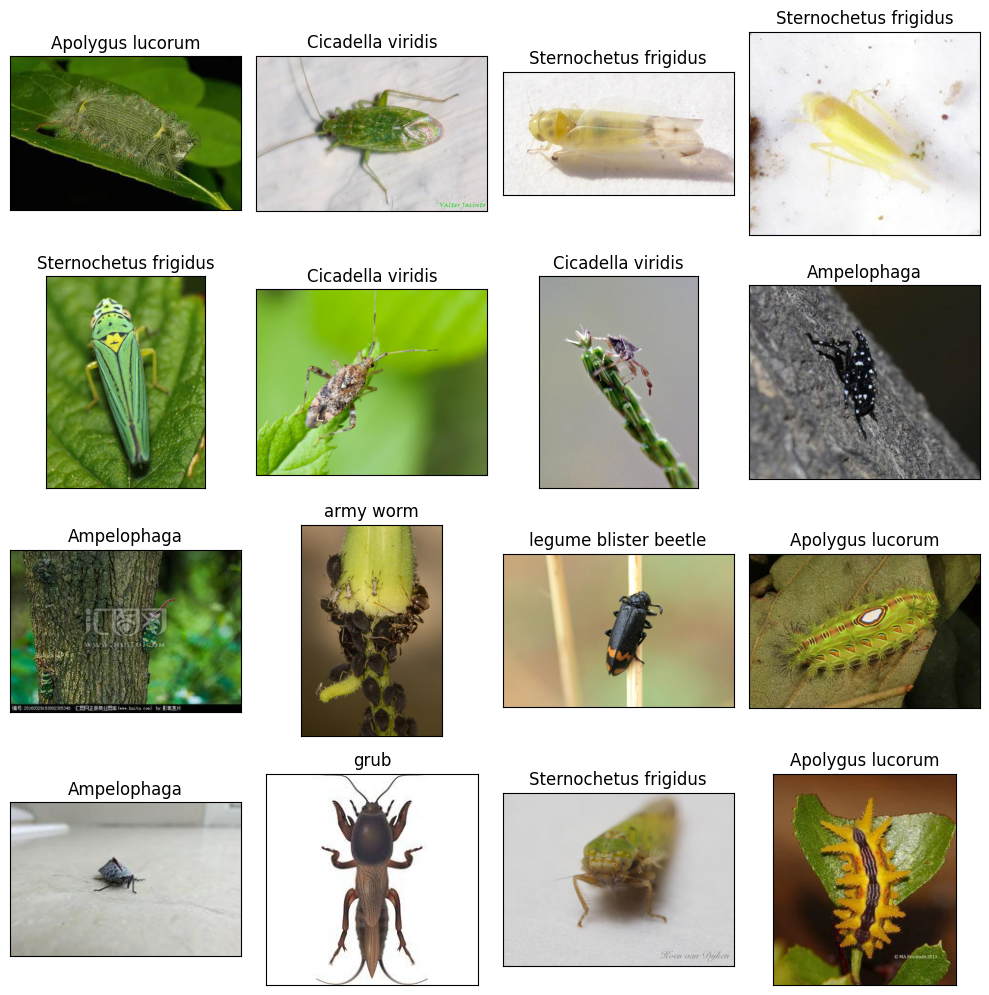

In [8]:
# Display random images
random_index = np.random.randint(0, len(train_df_img.label), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):    
    ax.imshow(plt.imread(train_df_img.image_fullpath[random_index[i]]))
    ax.set_title(get_lable(train_df_img.label[random_index[i]]))
plt.tight_layout()
plt.show()

In [ ]:
train_df_img['label'] = train_df_img['label'].astype(str)
val_df_img['label'] = val_df_img['label'].astype(str)
test_df_img['label'] = test_df_img['label'].astype(str)

In [ ]:
# Parameters
IMAGE_SIZE = 224  # Custom size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = len(choose_label_index)  # Number of classes

In [ ]:
# Create data generators for training, validation, and test sets
# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale = 1/255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
    
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

valid_datagen = ImageDataGenerator(rescale = 1/255)

valid_gen= valid_datagen.flow_from_dataframe(
    dataframe=val_df_img,
    x_col='image_fullpath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
STEP_SIZE_TRAIN = train_gen.n //train_gen.batch_size 
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size 

In [ ]:
# Define the ResNet model
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = ResNet50(include_top=False, input_tensor=input_tensor, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
#checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)


In [ ]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[early_stopping_callbacks]
)


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model(Correction Test accuracy)
loss, accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
# Save the model
model.save('resnet50_model.h5')  # Save the entire model to a file
print("Model saved as 'resnet50_model.h5'")
